# Final Project: S&P 500 (SPY) Buy/Sell

### Introduction

My original plan was to treat the Tesla Stock as a **regression** problem by using **Linear Regression** to predict future prices directly. After some research and suggestion i learned very quickly that predicting the stock market is more difficult than i assumed. I adjusted my approach to a simple buy/sell indicator model: instead of forecasting an exact future price, I reframed the problem as **binary classification** (1 = price is higher after 10 trading days, 0 = not higher). I built basic “chart‑style” features from OHLCV (Open, High, Low, Close, and Volume) data with additional feature analysis(returns, log returns, rolling averages, and simple moving‑average comparisons) and trained a **Perceptron** model. Performance is than evaluated using **accuracy** and **K‑Fold cross‑validation** on the training set to estimate how stable the accuracy is across different splits.


- Imported pandas for working with tables (DataFrames) to clean, columns selection, and saving CSV files.
- Imported  numpy for math operations (log, arrays) ect.
- Imported matplotlib for charts and basic ploting (we will plot the confusion matrix)
- Imported yfinance to download market data from Yahoo Finance.
- Imported KFold for K-Fold cross-validation. It split training data into folds
- Imported cross_val_score to measure cross-validation accuracy.
- Imported StandardScaler to scale features (helps Perceptron training)
- Imported Perceptron for a simple linear classification model.
- Imported Pipeline to combine scaling + model in one object.
- Imported accuracy_score to compute accuracy
- Imported confusion_matrix to build the 2x2 confusion matrix.
- Imported classification_report for readable metrics summary.

In [113]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline  
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import classification_report 


In [114]:
# Choose the ticker symbol for the S&P 500 ETF (SPY).
ticker = "SPY"  
# Choose a start date to have enough history for rolling features.
start_date = "2015-01-01"  
# Download the data from Yahoo Finance.
df_raw = yf.download(ticker, start=start_date, auto_adjust=True)  # auto_adjust=True uses adjusted prices.

if isinstance(df_raw.columns, pd.MultiIndex):  # check whether columns have multiple levels.
    df_raw.columns = df_raw.columns.get_level_values(0)  # keep only the first level (OHLCV names).

df_raw.head()  # show the top rows in the table.


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,171.093689,172.301341,170.052618,171.884913,121465900
2015-01-05,168.003754,170.210818,167.695601,170.044249,169632600
2015-01-06,166.421387,168.836665,165.621839,168.311962,209151400
2015-01-07,168.495163,168.836637,167.304185,167.753921,125346700
2015-01-08,171.485153,171.701704,169.894407,169.911055,147217800


In [115]:
# Make a copy so we do not accidentally overwrite the raw data.
df = df_raw.copy()  

# Pick the price column to use as the main “close” price.
price_col = "Close"  

# Create new return column to calculate percentage change from previous close.
df["return"] = df[price_col].pct_change() 

# Create log return dispaly difference of log prices.
df["log_ret"] = np.log(df[price_col]).diff()  

# Create 10-day rolling mean of Low 
df["df_l"] = df["Low"].rolling(window=10).mean()  # average Low over last 10 trading days.

# Create 10-day rolling mean of High 
df["df_hmi"] = df["High"].rolling(window=10).mean()  # average High over last 10 trading days.

# Create a 10-day simple moving average of Close.
df["sma10"] = df[price_col].rolling(window=10).mean()  # average Close over 10 days.

# Create a 20-day simple moving average of Close.
df["sma20"] = df[price_col].rolling(window=20).mean()  # average Close over 20 days.

# Compare Close to SMA10 
df["close_vs_sma10"] = (df[price_col] / df["sma10"]) - 1  # positive means above SMA10, negative means below.

# Compare Close to SMA20 .
df["close_vs_sma20"] = (df[price_col] / df["sma20"]) - 1  # another trend indicator.

horizon = 10  # how far ahead we look to label buy/sell for 10 trading days ~ 2 weeks

# Target column (1 if future Close is higher than today, else 0).
df["Target"] = (df[price_col].shift(-horizon) > df[price_col]).astype(int) 

# Selected columns we need for modeling (inputs + target).
df_model = df[["Volume", "Open", "High", "Low", "Close", "return", "log_ret",
                "df_l", "df_hmi", "close_vs_sma10", "close_vs_sma20", "Target"]].copy() 

# Drop rows with missing values (NaNs)
df_model = df_model.dropna()  # scikit-learn keeps giving errors.

df_model = df_model.round(4)  # limit decimals to keep tables readable.

# Show the dataset preview.
df_model.head()  


Price,Volume,Open,High,Low,Close,return,log_ret,df_l,df_hmi,close_vs_sma10,close_vs_sma20,Target
Date,,,,,,,,,,,,
2015-01-30,197729700,167.0460,168.3785,165.8467,166.1132,-0.0126,-0.0127,167.4133,169.8194,-0.0163,-0.0155,1
2015-02-02,163107000,166.6129,168.2620,164.7890,168.1704,0.0124,0.0123,167.3558,169.8369,-0.0043,-0.0024,1
2015-02-03,124212900,169.0699,170.6107,168.6951,170.6023,0.0145,0.0144,167.5541,170.0143,0.0087,0.0112,1
2015-02-04,134306700,169.8361,171.0521,169.4947,169.9527,-0.0038,-0.0038,167.7681,170.1576,0.0044,0.0063,1
2015-02-05,97953200,170.6189,171.8183,170.5440,171.6683,0.0101,0.0100,167.9713,170.1609,0.0145,0.0155,1


In [116]:
# Save the cleansed dataset to a CSV file.
clean_csv_path = "clean_spy_dataset.csv" 
df_model.to_csv(clean_csv_path, index=True)  # write the CSV to disk with the date index.

# Print the filename so you know what was created.
print("Saved cleansed dataset to:", clean_csv_path)  # also show where the file is saved.


Saved cleansed dataset to: clean_spy_dataset.csv


In [117]:
# Create a list of feature to inputs into the model
feature_cols = [  
    "Volume",
    "Open",
    "High",
    "Low",
    "Close",
    "return",  #daily return.
    "log_ret",  #daily log return.
    "df_l",  #10-day average Low.
    "df_hmi",  #10-day average High.
    "close_vs_sma10",  #Close compared to SMA10.
    "close_vs_sma20",  #Close compared to SMA20.
]

# X (features) and y (target).
X = df_model[feature_cols].copy()
y = df_model["Target"].copy()

# Split the data into train and test sets 
train_fraction = 0.80  # 80% train, 20% test.
train_size = int(len(df_model) * train_fraction)  

# Use the first 80% of rows for training 
X_train = X.iloc[:train_size].copy()  
y_train = y.iloc[:train_size].copy()  

# Use the last 20% of rows for testing 
X_test = X.iloc[train_size:].copy()  
y_test = y.iloc[train_size:].copy()  

# Print sizes to verify the split.
print("Train rows:", len(X_train), "Test rows:", len(X_test))  


Train rows: 2190 Test rows: 548


Build a simple pipeline: scale features, then fit a perceptron classifier. Pipeline ensures we scale and predict consistently
K-Fold Splitter a model evaluation technique that involves splitting the dataset into 'k' equal-sized subsets, or folds, to provide a reliable estimate of a model's performance to prevent overfitting that can occur with a single train-test split. 

In [118]:
model = Pipeline([ 
    ("scaler", StandardScaler()),  # scale each feature to mean=0, std=1.
    ("clf", Perceptron(random_state=42, max_iter=2000, tol=1e-4)),  # linear decision model.
]) 

k = 5  # number of folds.
kf = KFold(n_splits=k, shuffle=False)  # shuffle=False keeps the rows in order since it time-series data.

# Run cross-validation on the trainnig data
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")

# Print cross-validation results.
print("K-Fold accuracies:", np.round(cv_scores, 3))  # show each fold's accuracy.
print("K-Fold mean accuracy:", round(float(cv_scores.mean()), 3))  # average accuracy.
print("K-Fold std deviation:", round(float(cv_scores.std()), 3))  # how much results vary.

# Fit the model 
model.fit(X_train, y_train) 

test_pred = model.predict(X_test)  # predicted 0/1 labels for test rows.

# Compute test accuracy.
test_acc = accuracy_score(y_test, test_pred)  

print("Test accuracy:", round(float(test_acc), 3))  # main metric (accuracy).
print(classification_report(y_test, test_pred, digits=3))  # precision/recall/F1.


K-Fold accuracies: [0.532 0.674 0.662 0.333 0.484]
K-Fold mean accuracy: 0.537
K-Fold std deviation: 0.125
Test accuracy: 0.445
              precision    recall  f1-score   support

           0      0.332     0.751     0.461       173
           1      0.726     0.304     0.429       375

    accuracy                          0.445       548
   macro avg      0.529     0.528     0.445       548
weighted avg      0.602     0.445     0.439       548



Confusion matrix (10 test records):
[[1 4]
 [3 2]]


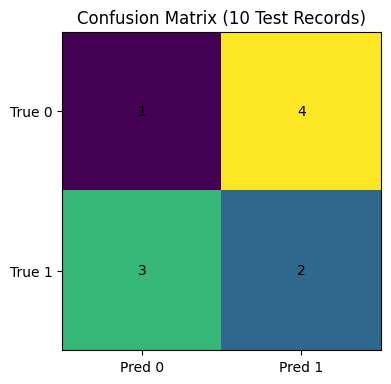

Saved supplemental file: confusion_matrix_10_records.png
Saved supplemental file: perceptron_coefficients.csv
Saved supplemental file: test_set_predictions.csv


In [119]:
# Select 10 records from the test set and creat a copy
X_test_10 = X_test.iloc[:10].copy()  
y_test_10 = y_test.iloc[:10].copy()  

# Run the perceptron on these 10 records.
pred_10 = model.predict(X_test_10)  

# Build a 2x2 confusion matrix.
cm_10 = confusion_matrix(y_test_10, pred_10, labels=[0, 1])  # rows=true, cols=pred.

# Print the confusion matrix numbers.
print("Confusion matrix (10 test records):")  
print(cm_10)  # show counts.

# Plot the confusion matrix 
plt.figure(figsize=(4, 4))
plt.imshow(cm_10)
plt.title("Confusion Matrix (10 Test Records)")
plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["True 0", "True 1"])
for i in range(2):
    for j in range(2): 
        plt.text(j, i, str(cm_10[i, j]), ha="center", va="center")  # print count in each cell.
plt.tight_layout()  # reduce extra whitespace.
plt.show()

# Save the confusion matrix figure as a file.
cm_png_path = "confusion_matrix_10_records.png"
plt.figure(figsize=(4, 4))
plt.imshow(cm_10)  
plt.title("Confusion Matrix (10 Test Records)")  
plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["True 0", "True 1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm_10[i, j]), ha="center", va="center")
plt.tight_layout()
plt.savefig(cm_png_path, dpi=150)
plt.close()  # close the figure

# Save the model coefficients as a CSV (decision model).
clf = model.named_steps["clf"]  # call out the perceptron inside the pipeline.
coef = clf.coef_.ravel()  # perceptron weights
coef_df = pd.DataFrame({"feature": feature_cols, "weight": coef})  # pair feature names with weights.
coef_csv_path = "perceptron_coefficients.csv"  # filename
coef_df.to_csv(coef_csv_path, index=False)  # save to CSV.

# Also save test predictions as a file (optional but useful).
pred_df = X_test.copy()  
pred_df["y_true"] = y_test.values 
pred_df["y_pred"] = test_pred
pred_csv_path = "test_set_predictions.csv" 
pred_df.to_csv(pred_csv_path, index=True)  # save to CSV.

print("Saved supplemental file:", cm_png_path)  # confusion matrix image.
print("Saved supplemental file:", coef_csv_path)  # perceptron weights.
print("Saved supplemental file:", pred_csv_path)  # test predictions.


In [120]:
# Get the most recent row in features
latest_X = X.iloc[[-1]].copy() 

# Predict the latest 10-day direction signal.
latest_signal = int(model.predict(latest_X)[0])  # 1 means predicted up, 0 means predicted not up.


print("Latest 10-day signal:", "BUY" if latest_signal == 1 else "SELL/ HOLD")  # interpret 1/0.


Latest 10-day signal: SELL/ HOLD


### *Summary Report (Findings, Data Anomalies Ect..)*

In this final project i builds a data‑driven model that mimics a basic version of real‑world chart analysis for the S&P 500 using the *SPY ETF* as the data source. Instead of predicting the exact future price (regression) as previously planned, i predicts a *directional signal* of the stock using binary classification:
- **Target = 1 (BUY)** if the *Close price 10 trading days in the future* is higher than today’s Close  
- **Target = 0 (SELL/HOLD)** otherwise
This framing produces a clear decision output that matches “buy vs. sell” for long term stock trading.

### Data source and cleansing steps
Daily historical OHLCV data (Open, High, Low, Close, Volume) is downloaded with `yfinance` using `auto_adjust=True`, which adjusts prices for splits/dividends. Than features are then created:
- `return` (percent change) and `log_ret` (log return)
- 10‑day rolling averages of Low and High (`df_l`, `df_hmi`)
- 10‑day and 20‑day moving averages (`sma10`, `sma20`)
- Close‑to‑SMA comparisons (`close_vs_sma10`, `close_vs_sma20`)

**Cleansing:** rolling averages and return calculations had produce missing values at the start of the dataset (for example, you cannot compute a 20‑day SMA until you have 20 rows). These missing rows are removed using `dropna()` so the final modeling dataset contains **no NaN values**. The cleansed dataset is saved as `clean_spy_dataset.csv`.

### Modeling approach
The final decision model is a **Perceptron** classifier wrapped in a pipeline:
1) `StandardScaler` standardizes each feature  
2) `Perceptron` learns a linear boundary to separate Target=1 from Target=0

The perceptron produces a decision based on the sign of a weighted sum
The learned weights are saved to `perceptron_coefficients.csv`.

### Evaluation and required confusion matrix
We evaluates the model in two ways as suggest in recent class lecture:
- **K‑Fold cross‑validation (K=5)** on the training set to estimate stability of accuracy across splits  
- **Hold‑out test set accuracy** using the most recent ~20% of rows as “future” data
And to satisfy project requirement, exactly **10 records from the test set** are run through the perceptron and a **2×2 confusion matrix** is generated and plotted. That plot is saved as `confusion_matrix_10_records.png`.

###  Key findings 
- The perceptron provides a *simple, explainable baseline* for direction prediction over a 10‑day horizon.
- The K‑Fold accuracy values show how consistent performance is across different training/validation splits.
- The test accuracy gives a realistic check using the newest portion of the data.
- The latest predicted output is printed as a plain‑English signal (**BUY** or **SELL/HOLD**).

### Data anomalies observed 
- **Missing values from feature engineering:** rolling windows and return calculations create NaNs at the start of the dataset. It must be handled ( by dropping rows or filling values) or the model will error.
- **Outliers and volatility clusters:** SPY price changes can be unusually large during crisis periods. 
- **Volume spikes:** volume can jump significantly during major market events. Volume is informative but may also reflect rare events that do not repeat often.
- **Market closures / uneven spacing:** the dataset contains trading days only (no weekends/holidays).

### Questions to ask about the data 
Should the horizon stay at **10 trading days**, or should it be tested at 5 / 20 to see sensitivity?


Supplemental files created

- `clean_spy_dataset.csv` (cleansed dataset used for modeling)
- `perceptron_coefficients.csv` (weights of the decision model)
- `test_set_predictions.csv` (test predictions and true labels)
- `confusion_matrix_10_records.png` (confusion matrix for 10 test records)